In [2]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#Importing Libraries 

In [3]:
import os
import skimage.io as io
import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd
from IPython.core.display import HTML
from torch.utils.data import Dataset, DataLoader
import cv2
import glob
import numpy
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import sklearn.externals
import joblib

In [4]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
import imageio
import cv2
import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean
# Charts
import matplotlib.pyplot as plt
import seaborn as sns

# ML, statistics
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

# Tensorflow
#from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception 

from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
!pip install tensorflow-addons
!pip install tensorflow-Ranking
import tensorflow_ranking as tfr
import tensorflow_addons as tfa
import tensorflow_probability as tfp

from tensorflow.keras.utils import plot_model

from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

     |████████████████████████████████| 1.1 MB 8.6 MB/s 
     |████████████████████████████████| 141 kB 9.5 MB/s 
     |████████████████████████████████| 462 kB 66.5 MB/s 


#Unzipping Dataset
##Taking 5000 images from Train set and 500 from Test set due to limitation of resources

In [7]:
import sys
import os, zipfile

#Unzipping the dataset
zip_ref = zipfile.ZipFile("/content/Dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()


### Training and Test set paths

In [11]:
train_dataset_path ='/content/gdrive/MyDrive/CV ASS2/Dataset/train_set/images'
train_labels_path='/content/gdrive/MyDrive/CV ASS2/Dataset/train_set/annotations'
test_dataset_path ='/content/gdrive/MyDrive/CV ASS2/Dataset/val_set/images'
test_labels_path='/content/gdrive/MyDrive/CV ASS2/Dataset/val_set/annotations'

# Train Set Dataframe

In [12]:
#Image paths to dataframe
Ind=[]
i=0
for dirname, _, filenames in os.walk(train_dataset_path):
    for filename in filenames:
        Ind.insert(1,os.path.join(dirname, filename))
        i=i+1
Image={"Image":Ind}
trainData = pd.DataFrame(Image) 
trainData

Image
0     /content/gdrive/MyDrive/CV ASS2/Dataset/train_...
1     /content/gdrive/MyDrive/CV ASS2/Dataset/train_...
2     /content/gdrive/MyDrive/CV ASS2/Dataset/train_...
3     /content/gdrive/MyDrive/CV ASS2/Dataset/train_...
4     /content/gdrive/MyDrive/CV ASS2/Dataset/train_...
...                                                 ...
3589  /content/gdrive/MyDrive/CV ASS2/Dataset/train_...
3590  /content/gdrive/MyDrive/CV ASS2/Dataset/train_...
3591  /content/gdrive/MyDrive/CV ASS2/Dataset/train_...
3592  /content/gdrive/MyDrive/CV ASS2/Dataset/train_...
3593  /content/gdrive/MyDrive/CV ASS2/Dataset/train_...

[3594 rows x 1 columns]

In [13]:
from functools import reduce
Val=[]
Exp=[]
Aro=[]
LM=[]
for cls_pth in glob.glob(train_labels_path+'/*'):
    a=cls_pth
    if (a.split('/')[-1]).endswith('_val.npy'):
      b=np.load(a)
      b=np.asarray(b).astype(np.float32) 
      Val.append(b)
    elif(a.split('/')[-1]).endswith('_exp.npy'):
      ex=np.load(a)
      ex=np.asarray(ex).astype(np.float32)
      Exp.append(ex)
    elif(a.split('/')[-1]).endswith('_aro.npy'):
      ar=np.load(a)
      ar=np.asarray(ar).astype(np.float32)
      Aro.append(ar)
    elif(a.split('/')[-1]).endswith('_lnd.npy'):
      lam=ar=np.load(a)
      lam=np.reshape(lam, (68,2), order='C')
      lam=np.asarray(lam).astype(np.float32)
      LM.append(lam)
    i=i+1
print(Val[0])
print(Exp[0])
print(Aro[0])
print(LM[0])
label1={"Expression":Exp}
label2={"Valance":Val}
label3={"Arosual":Aro}
Landmark={"Landmarks":LM}
dflm= pd.DataFrame(Landmark) 
dfy1 = pd.DataFrame(label1) 
dfy1['Expression'] = dfy1['Expression'].astype(float, errors = 'raise')
dfy2 = pd.DataFrame(label2)
dfy2['Valance'] = dfy2['Valance'].astype(float, errors = 'raise')
dfy3 = pd.DataFrame(label3)
dfy3['Arosual'] = dfy3['Arosual'].astype(float, errors = 'raise')
dfall= pd.concat([trainData,dflm, dfy1,dfy2,dfy3], axis=1)
dfall.to_csv('/content/gdrive/MyDrive/CV ASS2/Trainfile.csv')
dfall

-0.324235
1.0
0.236703
[[  4.7799654  83.59451  ]
 [  3.5645218 109.32415  ]
 [  5.711026  136.75789  ]
 [ 13.178991  164.60606  ]
 [ 26.474852  188.53513  ]
 [ 44.92466   208.3593   ]
 [ 67.22337   224.02858  ]
 [ 94.33321   235.27145  ]
 [120.74574   235.16785  ]
 [148.61523   228.0227   ]
 [169.65176   211.76396  ]
 [186.11868   191.13953  ]
 [198.39388   167.94641  ]
 [205.35152   143.41002  ]
 [206.89029   117.26597  ]
 [203.81273    92.333015 ]
 [200.75464    70.361725 ]
 [ 23.33106    69.12204  ]
 [ 35.949078   56.271515 ]
 [ 54.371616   52.07732  ]
 [ 73.90442    52.677513 ]
 [ 91.46212    58.89378  ]
 [127.7696     55.66775  ]
 [143.64438    47.743797 ]
 [160.58267    44.089058 ]
 [178.33516    45.200127 ]
 [190.1273     55.849953 ]
 [112.802505   79.2074   ]
 [114.7776     96.548645 ]
 [116.69037   113.318275 ]
 [118.37328   131.23471  ]
 [ 90.725845  138.75853  ]
 [104.25155   142.95273  ]
 [118.19798   146.38597  ]
 [130.65239   140.97353  ]
 [141.2096    135.46463  ]
 [ 48

Image  \
0     /content/gdrive/MyDrive/CV ASS2/Dataset/train_...   
1     /content/gdrive/MyDrive/CV ASS2/Dataset/train_...   
2     /content/gdrive/MyDrive/CV ASS2/Dataset/train_...   
3     /content/gdrive/MyDrive/CV ASS2/Dataset/train_...   
4     /content/gdrive/MyDrive/CV ASS2/Dataset/train_...   
...                                                 ...   
3589  /content/gdrive/MyDrive/CV ASS2/Dataset/train_...   
3590  /content/gdrive/MyDrive/CV ASS2/Dataset/train_...   
3591  /content/gdrive/MyDrive/CV ASS2/Dataset/train_...   
3592  /content/gdrive/MyDrive/CV ASS2/Dataset/train_...   
3593  /content/gdrive/MyDrive/CV ASS2/Dataset/train_...   

                                              Landmarks  Expression   Valance  \
0     [[4.7799654, 83.59451], [3.5645218, 109.32415]...         1.0 -0.324235   
1     [[14.84, 82.34126], [14.0, 105.30836], [14.540...         0.0 -0.508069   
2     [[19.778814, 81.5196], [21.556252, 107.02802],...         1.0 -0.873016   
3     [[24.626938, 95.25276], [27.487347, 117.99946]...         6.0  0.000000   
4     [[49.30654, 96.74615], [49.481705, 115.40917],...         1.0 -0.149795   
...                                                 ...         ...       ...   
3589  [[16.001768, 100.25295], [15.172597, 121.20185...         3.0  0.841097   
3590  [[21.052567, 76.33111], [20.589119, 99.78111],...         2.0 -0.830654   
3591  [[16.702, 56.9973], [16.516, 85.43018], [18.44...         1.0 -0.430701   
3592  [[5.8036366, 76.895], [7.5981817, 100.07667], ...         0.0  0.198413   
3593  [[0.09739131, 79.742065], [2.8135266, 105.5793...         1.0  0.004313   

       Arosual  
0     0.236703  
1    -0.301587  
2     0.115887  
3     0.542328  
4    -0.182540  
...        ...  
3589  0.115887  
3590  0.715817  
3591  0.100084  
3592  0.111305  
3593 -0.047408  

[3594 rows x 5 columns]

#Landmark incorporation to Images

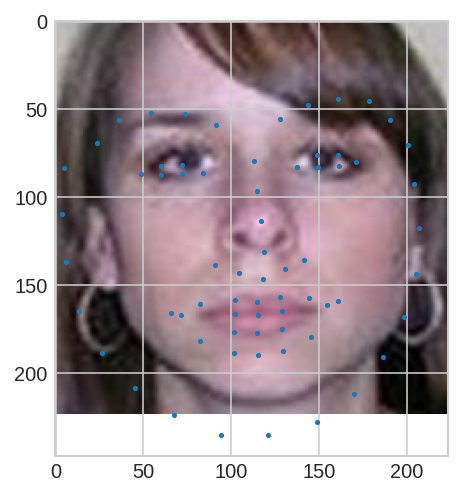

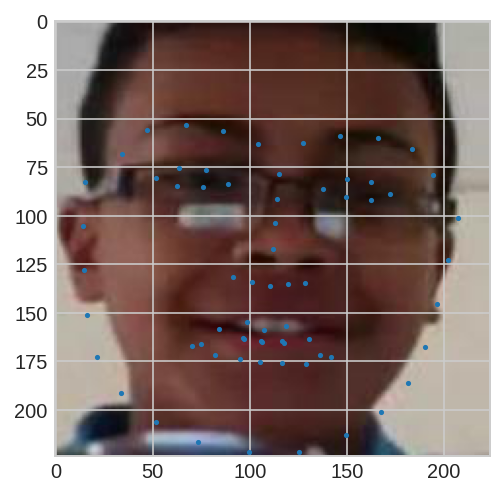

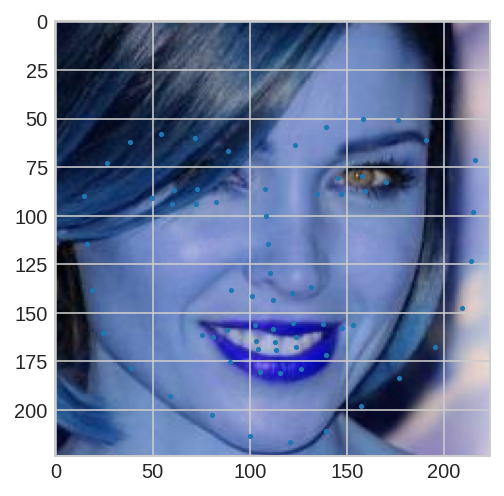

In [14]:
landmarks_frame = dfall.Landmarks

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.')
    plt.pause(0.001)

plt.figure()
show_landmarks(io.imread(dfall.Image[0]), dfall.Landmarks[0])
show_landmarks(io.imread(dfall.Image[1]), dfall.Landmarks[1])
show_landmarks(cv2.imread(dfall.Image[5]), dfall.Landmarks[5])
plt.show()

#Test Set Dataframe

In [15]:
Ind=[]
i=0
for dirname, _, filenames in os.walk(test_dataset_path):
    for filename in filenames:
        Ind.insert(1,os.path.join(dirname, filename))
        i=i+1
Image={"Image":Ind}
dfx_test = pd.DataFrame(Image) 
dfx_test

Image
0    /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...
1    /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...
2    /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...
3    /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...
4    /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...
..                                                 ...
351  /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...
352  /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...
353  /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...
354  /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...
355  /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...

[356 rows x 1 columns]

In [17]:
from functools import reduce
Val=[]
Exp=[]
Aro=[]
LM=[]
for cls_pth in glob.glob(test_labels_path+'/*'):
    a=cls_pth
    if (a.split('/')[-1]).endswith('_val.npy'):
      b=np.load(a)
      b=np.asarray(b).astype(np.float32) 
      Val.append(b)
    elif(a.split('/')[-1]).endswith('_exp.npy'):
      ex=np.load(a)
      ex=np.asarray(ex).astype(np.float32)
      Exp.append(ex)
    elif(a.split('/')[-1]).endswith('_aro.npy'):
      ar=np.load(a)
      ar=np.asarray(ar).astype(np.float32)
      Aro.append(ar)
    elif(a.split('/')[-1]).endswith('_lnd.npy'):
      lam=ar=np.load(a)
      lam=np.reshape(lam, (68,2), order='C')
      lam=np.asarray(lam).astype(np.float32)
      LM.append(lam)
    i=i+1
print(Val[0])
print(Exp[0])
print(Aro[0])
print(LM[0])
label1={"Expression":Exp}
label2={"Valance":Val}
label3={"Arosual":Aro}
Landmark={"Landmarks":LM}
dflm_test= pd.DataFrame(Landmark) 
dfy1_test = pd.DataFrame(label1) 
dfy1_test['Expression'] = dfy1['Expression'].astype(float, errors = 'raise')
dfy2_test = pd.DataFrame(label2)
dfy2_test['Valance'] = dfy2['Valance'].astype(float, errors = 'raise')
dfy3_test = pd.DataFrame(label3)
dfy3_test['Arosual'] = dfy3['Arosual'].astype(float, errors = 'raise')
dfall_test= pd.concat([dfx_test,dflm_test, dfy1_test,dfy2_test,dfy3_test], axis=1)
dfall_test.to_csv('/content/gdrive/MyDrive/CV ASS2/file1_test.csv')
dfall_test

-0.873016
7.0
0.542328
[[ 21.359701  98.76112 ]
 [ 25.957153 120.15155 ]
 [ 33.07146  142.8276  ]
 [ 42.484493 163.87492 ]
 [ 53.562847 184.40169 ]
 [ 70.635506 200.27493 ]
 [ 91.953255 212.72507 ]
 [114.41618  221.71268 ]
 [136.52255  222.18987 ]
 [157.62637  216.65295 ]
 [178.52464  203.13803 ]
 [198.17288  187.59605 ]
 [213.8361   166.42253 ]
 [220.9672   142.47662 ]
 [221.93617  117.418594]
 [221.46217   90.22704 ]
 [219.57034   63.36676 ]
 [ 32.081497  79.47268 ]
 [ 41.922398  67.15268 ]
 [ 58.676254  64.778595]
 [ 76.0761    66.23775 ]
 [ 91.98682   70.50479 ]
 [117.52869   64.60902 ]
 [135.05019   55.219154]
 [153.67491   49.638874]
 [172.78622   50.44338 ]
 [189.63655   57.707607]
 [106.211235  82.26084 ]
 [108.090485  98.481125]
 [109.843895 114.75268 ]
 [111.81123  131.40675 ]
 [ 96.189964 142.3583  ]
 [106.50487  145.21352 ]
 [116.194756 146.37296 ]
 [125.649734 142.13747 ]
 [134.46292  137.74423 ]
 [ 51.33543   89.20169 ]
 [ 60.91206   81.85859 ]
 [ 74.318504  80.88451 ]
 [

Image  \
0    /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...   
1    /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...   
2    /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...   
3    /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...   
4    /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...   
..                                                 ...   
351  /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...   
352  /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...   
353  /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...   
354  /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...   
355  /content/gdrive/MyDrive/CV ASS2/Dataset/val_se...   

                                             Landmarks  Expression   Valance  \
0    [[21.359701, 98.76112], [25.957153, 120.15155]...         1.0 -0.324235   
1    [[-13.187436, 95.01428], [-12.7183895, 119.362...         0.0 -0.508069   
2    [[7.7019176, 83.60752], [6.3415527, 106.85949]...         1.0 -0.873016   
3    [[21.982222, 104.10064], [26.382223, 125.76453...         6.0  0.000000   
4    [[26.339699, 91.77246], [23.469347, 119.91316]...         1.0 -0.149795   
..                                                 ...         ...       ...   
351  [[-3.9593513, 100.72983], [2.6062703, 123.8175...         1.0 -0.417849   
352  [[2.2141538, 128.92728], [13.465846, 152.47273...         1.0  0.568900   
353  [[8.126087, 93.949974], [11.6504345, 120.88908...         1.0 -0.769841   
354  [[14.038812, 96.80643], [16.083643, 119.59474]...         1.0 -0.023810   
355  [[5.8036366, 76.895], [7.5981817, 100.07667], ...         1.0  0.774866   

      Arosual  
0    0.236703  
1   -0.301587  
2    0.115887  
3    0.542328  
4   -0.182540  
..        ...  
351  0.242131  
352  0.405452  
353  0.525057  
354 -0.073459  
355  0.000000  

[356 rows x 5 columns]

#Data Augmentation
##Creating Generators for Train, Validation and Test sets 

In [18]:

class Generators:
    def __init__(self, train_df, test_df):
        self.batch_size=64
        self.img_size=(224,224)
        _datagen = ImageDataGenerator(
            rescale=None,
            validation_split=0.25,
            featurewise_center=False,
            featurewise_std_normalization=True,
            rotation_range=90,
            width_shift_range=0.2,            
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            dtype=float
            )
        # Train generator
        self.train_generator = _datagen.flow_from_dataframe(
            dataframe=train_df,
            directory='/content/gdrive/MyDrive/CV ASS2/Dataset/train_set/images',
            x_col=np.asarray("Image"),
            y_col=['Expression','Valance','Arosual'],
            image_size=(224,224),
            has_ext=False,
            subset="training",
            batch_size=self.batch_size,
            seed=42,
            shuffle=True,
            class_mode="multi_output",            
            target_size=self.img_size)
       
        # Validation generator
        self.val_generator = _datagen.flow_from_dataframe(
            dataframe=train_df,
            directory='/content/gdrive/MyDrive/CV ASS2/Dataset/train_set/images',    
            x_col="Image",
            y_col=['Expression','Valance','Arosual'],
            has_ext=False,
            subset="validation",
            batch_size=self.batch_size,
            seed=42,
            shuffle=True,
            class_mode="multi_output",
            target_size=self.img_size)   

        #test generator 
        test_datagen=ImageDataGenerator(rescale=1./255.)
       
        self.test_generator=test_datagen.flow_from_dataframe(
        dataframe=dfall_test,
        directory="/content/gdrive/MyDrive/CV ASS2/Dataset/val_set/images",
        x_col="Image",
        y_col=['Expression','Valance','Arosual'],
        batch_size=self.batch_size,
        seed=42,
        shuffle=False,
        class_mode="multi_output",
        target_size=self.img_size)    
        print('Test generator created')
             
# Create generators        
generators = Generators(dfall, dfall_test)            

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)


Found 2696 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 898 validated image filenames.
Found 356 validated image filenames.
Test generator created




#XCEPTION Transfer Learning

In [40]:

class ModelTrainer:
    """
    Create and fit the model
    """
    
    def __init__(self, generators):
        self.generators = generators
        self.img_width = generators.img_size[0]
        self.img_height = generators.img_size[1]
        
    def create_model(self, base_model):
      visible = Input(shape=(224,224,3))
      x= base_model(visible, training=True)
      flat = GlobalAveragePooling2D()(x)
      hidden1 = Dense(2048, activation='relu')(flat)
      hidden1 = Dense(1024, activation='relu')(hidden1)

      expression = Dense(8, name='expression')(hidden1)
      valence = Dense(1, activation='linear', name='valence')(hidden1)
      arrousal = Dense(1, activation='linear', name='arrousal')(hidden1)

      model = Model(inputs=visible, outputs=[expression,valence,arrousal])
      model.compile(optimizer=Adam(learning_rate=0.001), 
                    loss=[SparseCategoricalCrossentropy(from_logits=True), MeanSquaredError(), MeanSquaredError()], 
                    metrics=['accuracy'])
      model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss=[SparseCategoricalCrossentropy(from_logits=True), MeanSquaredError(), MeanSquaredError()],
                    loss_weights={'expression': 5, 'valence': 0.25, 'arrousal':0.25},
                    metrics={'expression':'accuracy','expression':tfa.metrics.CohenKappa(num_classes=8,sparse_labels=True),'valence': 'RootMeanSquaredError', 'arrousal':'RootMeanSquaredError'})
      
      [print(i.shape, i.dtype) for i in model.inputs]
      [print(o.shape, o.dtype) for o in model.outputs]
      [print(l.name, l.input_shape, l.dtype) for l in model.layers]

      return model
        
    
    def train(self, model, typeModel ):
       
        epochs=10
        validation_steps=5
            
        # We'll stop training if no improvement after some epochs
        reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
        
        # Save the best model during the traning
        checkpointer = ModelCheckpoint('/content/gdrive/MyDrive/CV ASS2/model' + str(typeModel) +'.h5'
                                        ,verbose=1
                                        ,save_weights_only=True)
        # Train
        training = model.fit_generator(generator=self.generators.train_generator
                                ,epochs=epochs
                                ,validation_data=self.generators.val_generator
                                ,validation_steps=validation_steps
                                ,callbacks=[checkpointer, reduce_lr])
        joblib.dump(model, '/content/gdrive/MyDrive/CV ASS2/model_' + str(typeModel) +'.pkl', compress=1)
        joblib.dump(training, '/content/gdrive/MyDrive/CV ASS2/training_' + str(typeModel) +'.pkl', compress=1)
        return training
   


(None, 224, 224, 3) <dtype: 'float32'>
(None, 8) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
input_6 [(None, 224, 224, 3)] float32
xception (None, 224, 224, 3) float32
global_average_pooling2d_2 (None, 7, 7, 2048) float32
dense_4 (None, 2048) float32
dense_5 (None, 2048) float32
expression (None, 1024) float32
valence (None, 1024) float32
arrousal (None, 1024) float32
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_6[0][0]']  

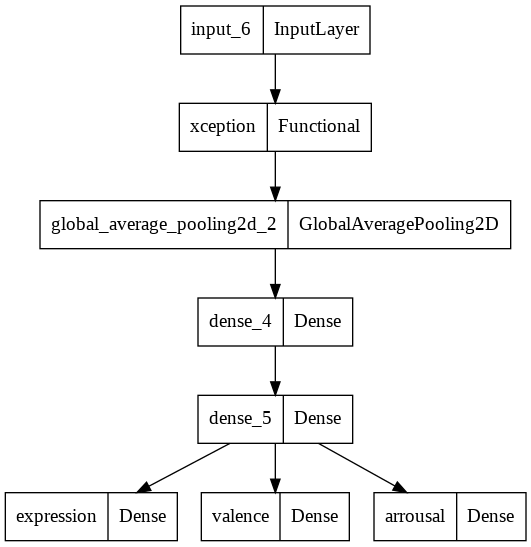

In [34]:
# Create and train the model

xc_base_model=Xception(weights="imagenet",
                             include_top=False,
                             input_shape =(224, 224,3))

trainer1 = ModelTrainer(generators)
model1= trainer1.create_model(xc_base_model)
model1.summary()
plot_model(model1, to_file='/content/gdrive/MyDrive/CV ASS2/xception_model.png')

In [35]:
typeModel="Xception"
training=trainer1.train(model1, typeModel)
print("Xception Trained")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/25
43/43 [==============================] - ETA: 0s - loss: 8.4295 - expression_loss: 1.6661 - valence_loss: 0.2842 - arrousal_loss: 0.1128 - expression_cohen_kappa: 9.8485e-04 - valence_root_mean_squared_error: 0.5331 - arrousal_root_mean_squared_error: 0.3359
Epoch 1: saving model to /content/gdrive/MyDrive/CV ASS2/modelXception.h5
43/43 [==============================] - 66s 1s/step - loss: 8.4295 - expression_loss: 1.6661 - valence_loss: 0.2842 - arrousal_loss: 0.1128 - expression_cohen_kappa: 9.8485e-04 - valence_root_mean_squared_error: 0.5331 - arrousal_root_mean_squared_error: 0.3359 - val_loss: 8.2928 - val_expression_loss: 1.6392 - val_valence_loss: 0.2751 - val_arrousal_loss: 0.1111 - val_expression_cohen_kappa: 0.0000e+00 - val_valence_root_mean_squared_error: 0.5245 - val_arrousal_root_mean_squared_error: 0.3334 - lr: 1.0000e-04
Epoch 2/25
43/43 [==============================] - ETA: 0s - loss: 8.1332 - expression_loss: 1.6074 - valence_loss: 0.2767 - arrousal_los

#Evaluation class for models

In [66]:
class Eval:
  
    def __init__(self, model, training, generator, y_true):
        self.training = training
        self.generator = generator

        steps=5
        self.expression, self.valance, self.arosual = model.predict_generator(self.generator, steps=steps)
        self.y_pred = np.argmax(self.expression, axis=1)
        self.y_true=y_true[:len(self.y_pred)] 

    def plot_history(self):
        fig, s = plt.subplots(2)
        s[0].plot(self.training.history['loss'], label="Loss")
        s[0].plot(self.training.history['val_loss'], label="Validation loss")
        s[0].set_title('Loss Plot')
        s[0].set_xlabel('Epoch')
        s[0].set_ylabel('Loss')
        s[0].legend()

        #Accuracy
        s[1].plot(self.training.history['expression_cohen_kappa'], label="cohen_kappa")
        s[1].plot(self.training.history['val_expression_cohen_kappa'], label="cohen_kappa validation")
        s[1].set_title('cohen_kappa')
        s[1].set_xlabel('Epoch')
        s[1].set_ylabel('cohen_kappa')
        s[1].legend()
        plt.tight_layout()
        plt.show()

    def print_report(self):
        print(metrics.classification_report(self.y_true, self.y_pred))
        SAGR=np.mean(np.sign(self.y_true) == np.sign(self.y_pred))
        print("SAGR : {}".format(SAGR))




##Quantitative Analysis of Xception

In [63]:
typeModel="Xception"
test_model=joblib.load('/content/gdrive/MyDrive/CV ASS2/model_' + str(typeModel) +'.pkl')
test_training=joblib.load('/content/gdrive/MyDrive/CV ASS2/training_' + str(typeModel) +'.pkl') #Loading saved history and model  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


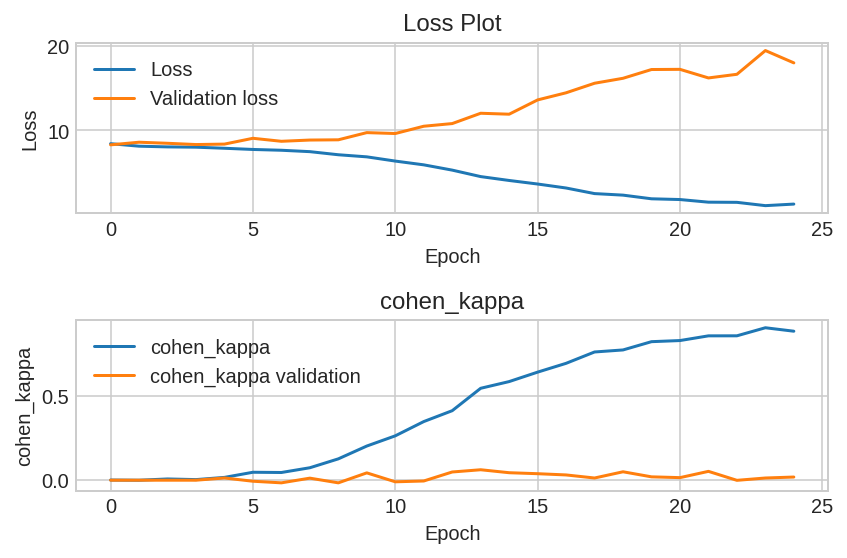

              precision    recall  f1-score   support

         0.0       0.28      0.28      0.28        79
         1.0       0.42      0.52      0.47       127
         2.0       0.12      0.10      0.11        30
         3.0       0.24      0.16      0.19        25
         4.0       0.00      0.00      0.00        11
         5.0       0.00      0.00      0.00        11
         6.0       0.08      0.07      0.08        27
         7.0       0.00      0.00      0.00        10

    accuracy                           0.30       320
   macro avg       0.14      0.14      0.14       320
weighted avg       0.27      0.30      0.29       320

SAGR : 0.64375


In [67]:
evaluator = Eval(test_model, test_training, generators.test_generator, dfall_test['Expression'])
evaluator.plot_history()
evaluator.print_report()

#Qualitative Analyis
##Correct and Incorrect Predicted Images 

In [56]:
emotion1, valance1, arosual1 = test_model.predict_generator(generators.test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Showing correct predictions
{256, 202, 266, 236, 305, 241, 21, 119}


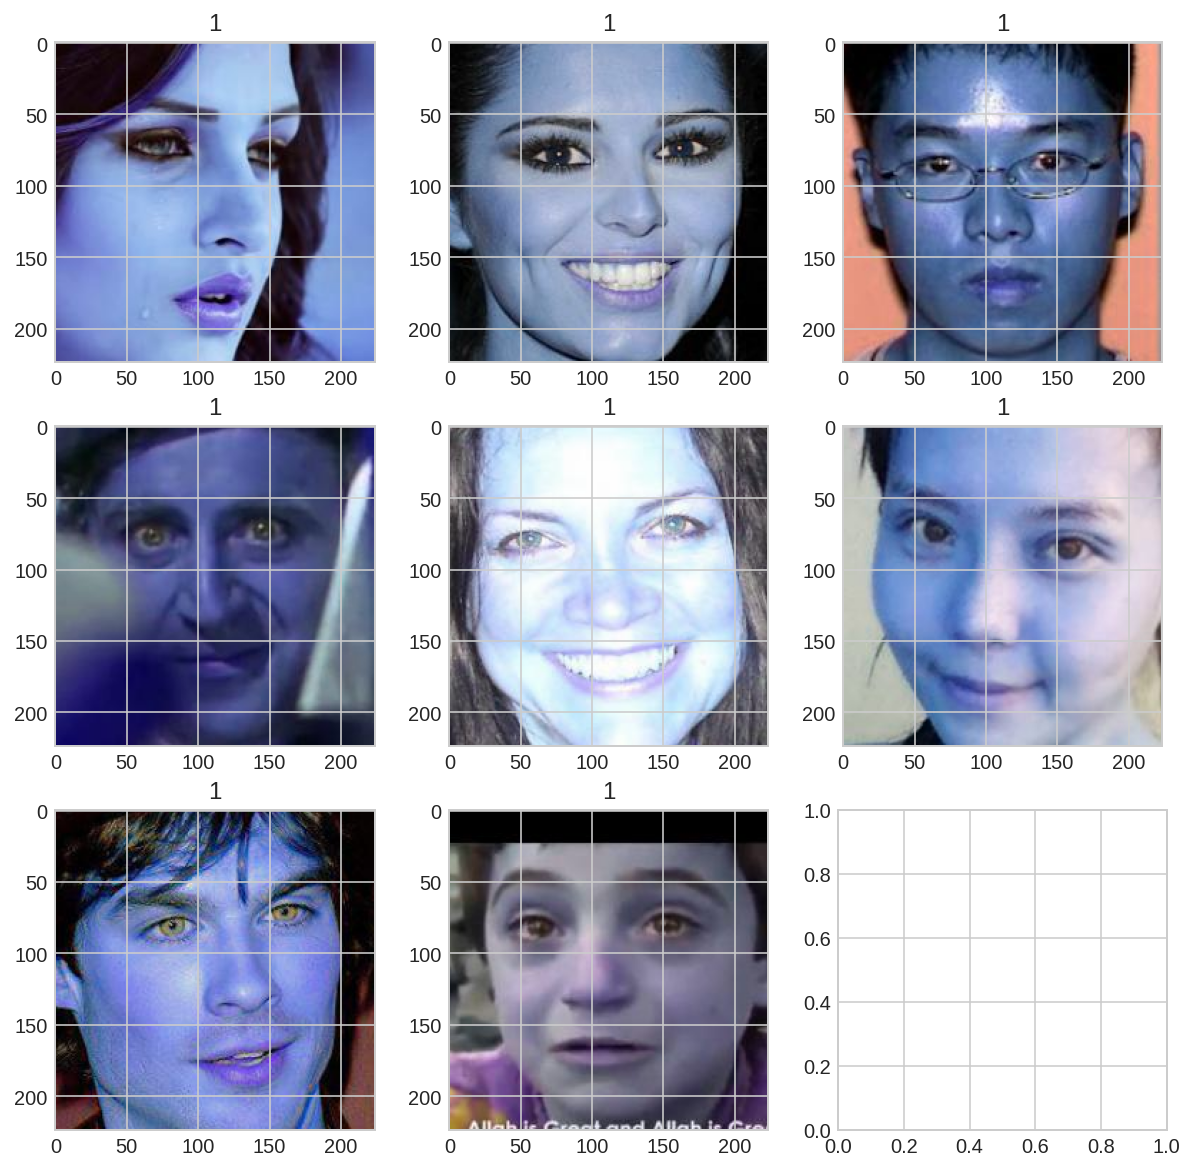

Showing wrong predictions
{73, 138, 173, 16, 81, 20, 151, 183, 124}


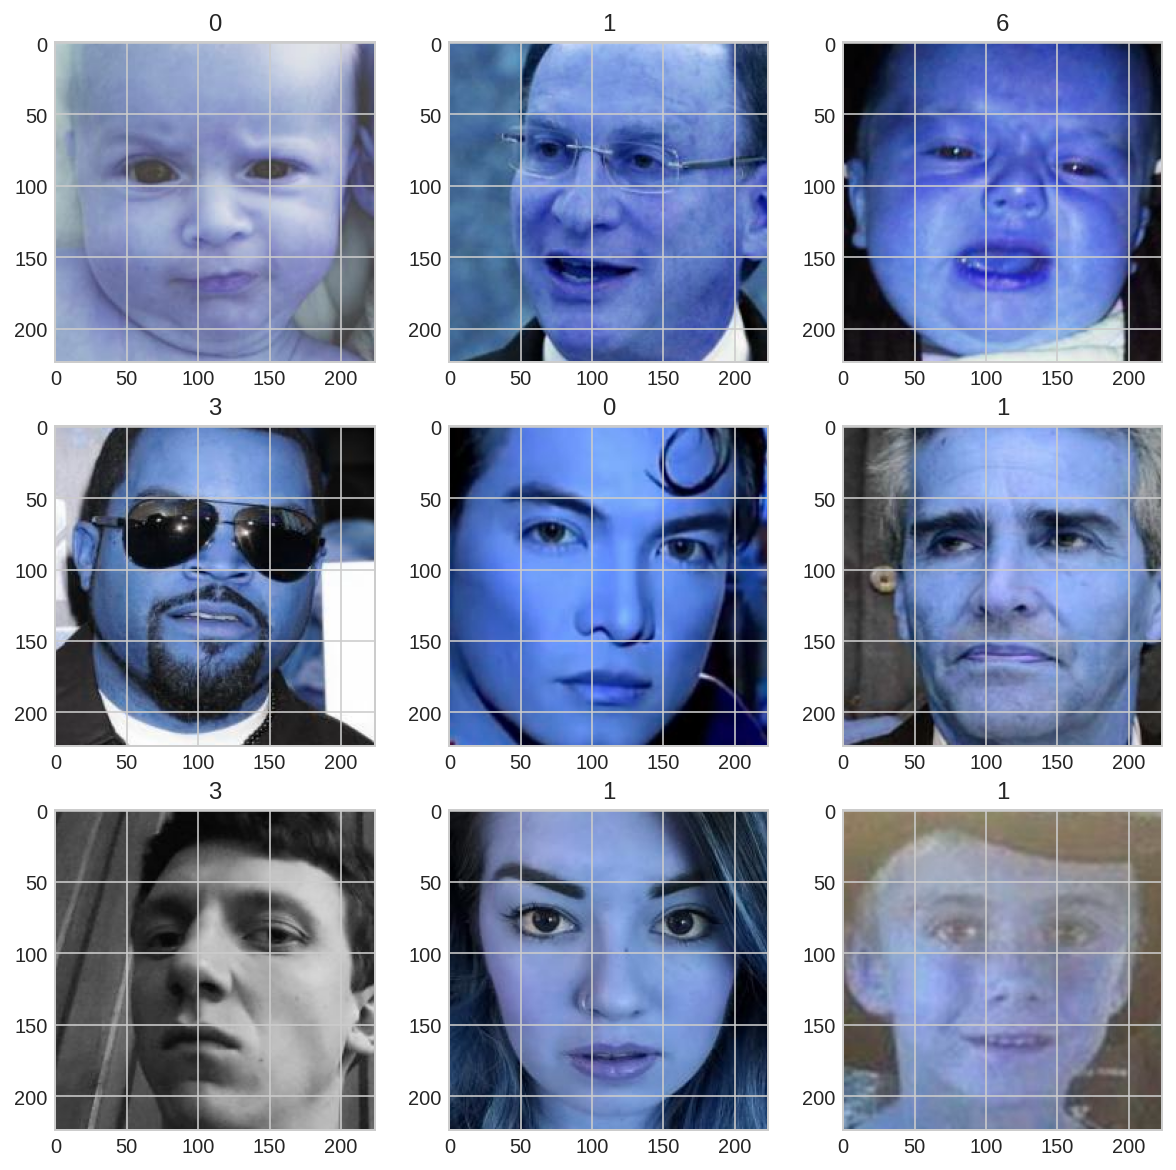

In [58]:
predictions = np.argmax(emotion1, axis=1)
image_paths = dfall_test['Image'][:len(predictions)]   
true_class=dfall_test['Expression'][:len(predictions)]  

#Seperating indices for correctly and incorrectly predicted samples
correct_preds = np.array(true_class) == np.array(predictions)
correct_inds, incorrect_inds = [],[]

for i,x in enumerate(correct_preds):
  if x:
    correct_inds.append(i)
  else:
    incorrect_inds.append(i)

#choose random correct and incorrect samples
correct_inds = set(np.random.choice(correct_inds, size=9))
incorrect_inds = set(np.random.choice(incorrect_inds, size=9))


print("Showing correct predictions")
print(correct_inds)
imgs, labels = [], []
for i,x in enumerate(correct_inds):
  imgs.append(cv2.imread(image_paths[x]))
  labels.append(predictions[x])
_, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    ax.imshow(img)
    ax.set_title(l)
plt.show()


print("Showing wrong predictions")
print(incorrect_inds)
imgs, labels = [], []
for i,x in enumerate(incorrect_inds):
  imgs.append(cv2.imread(image_paths[x]))
  labels.append(predictions[x])
_, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
   ax.imshow(img)
   ax.set_title(l)
plt.show()

# ResNet Transfer Learning

In [41]:
v_base_model = VGG16(weights= 'imagenet', 
                  include_top=False, 
                  input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 0s 0us/step


(None, 224, 224, 3) <dtype: 'float32'>
(None, 8) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
input_8 [(None, 224, 224, 3)] float32
vgg16 (None, 224, 224, 3) float32
global_average_pooling2d_3 (None, 7, 7, 512) float32
dense_6 (None, 512) float32
dense_7 (None, 2048) float32
expression (None, 1024) float32
valence (None, 1024) float32
arrousal (None, 1024) float32
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_8[0][0]']       

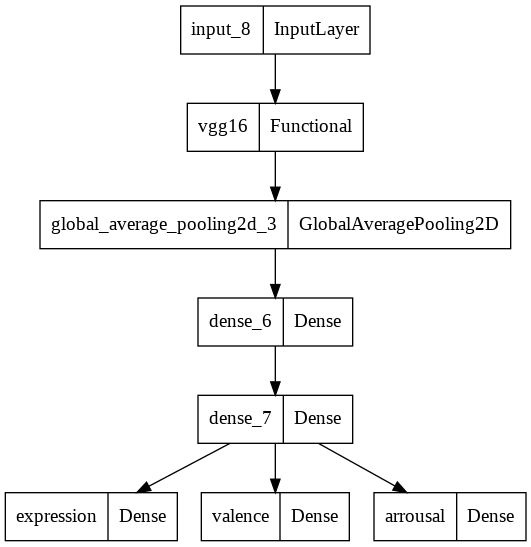

In [42]:
# Create and train the model

trainer2 = ModelTrainer(generators)
model2= trainer2.create_model(v_base_model)
model2.summary()
plot_model(model2, to_file='/content/gdrive/MyDrive/CV ASS2/vgg16_model.png')

In [43]:
modelType="VGG16"
training2=trainer2.train(model2,modelType)
print("VGG16 Trained")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
43/43 [==============================] - ETA: 0s - loss: 8.6824 - expression_loss: 1.7088 - valence_loss: 0.3843 - arrousal_loss: 0.1700 - expression_cohen_kappa: -0.0070 - valence_root_mean_squared_error: 0.6200 - arrousal_root_mean_squared_error: 0.4123
Epoch 1: saving model to /content/gdrive/MyDrive/CV ASS2/modelVGG16.h5
43/43 [==============================] - 65s 1s/step - loss: 8.6824 - expression_loss: 1.7088 - valence_loss: 0.3843 - arrousal_loss: 0.1700 - expression_cohen_kappa: -0.0070 - valence_root_mean_squared_error: 0.6200 - arrousal_root_mean_squared_error: 0.4123 - val_loss: 8.4801 - val_expression_loss: 1.6754 - val_valence_loss: 0.2830 - val_arrousal_loss: 0.1291 - val_expression_cohen_kappa: 0.0000e+00 - val_valence_root_mean_squared_error: 0.5320 - val_arrousal_root_mean_squared_error: 0.3594 - lr: 1.0000e-04
Epoch 2/10
43/43 [==============================] - ETA: 0s - loss: 8.1872 - expression_loss: 1.6181 - valence_loss: 0.2818 - arrousal_loss: 0.1056

In [69]:
modelType="VGG16"
test_model2=joblib.load('/content/gdrive/MyDrive/CV ASS2/model_' + str(typeModel) +'.pkl')
test_training2=joblib.load('/content/gdrive/MyDrive/CV ASS2/training_' + str(typeModel) +'.pkl')

##Quantitative Analysis of ResNet

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


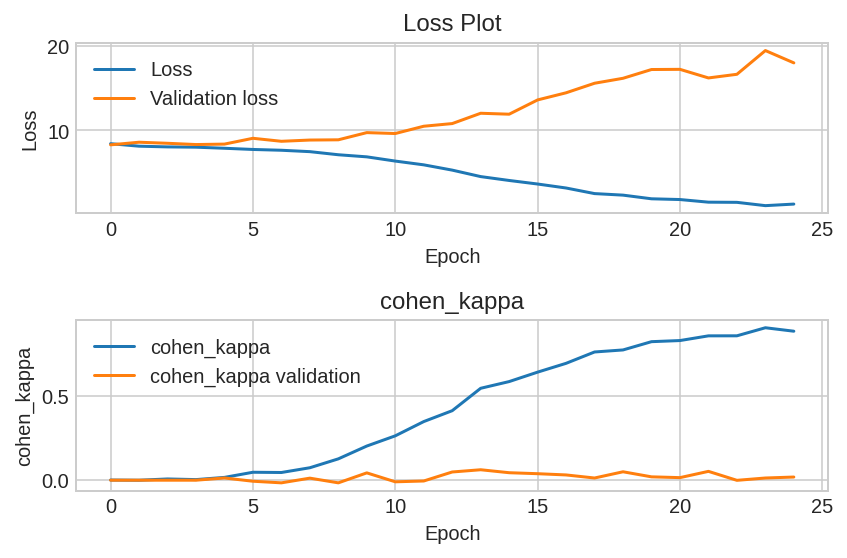

              precision    recall  f1-score   support

         0.0       0.28      0.28      0.28        79
         1.0       0.42      0.52      0.47       127
         2.0       0.12      0.10      0.11        30
         3.0       0.24      0.16      0.19        25
         4.0       0.00      0.00      0.00        11
         5.0       0.00      0.00      0.00        11
         6.0       0.08      0.07      0.08        27
         7.0       0.00      0.00      0.00        10

    accuracy                           0.30       320
   macro avg       0.14      0.14      0.14       320
weighted avg       0.27      0.30      0.29       320

SAGR : 0.64375


In [70]:
evaluator2 = Eval(test_model2, test_training2, generators.test_generator, dfall_test['Expression'])
evaluator2.plot_history()
evaluator2.print_report()

## Qualitative Analysis of ResNet

In [71]:
emotion, valance, arosual = test_model2.predict_generator(generators.test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [72]:
predictions = np.argmax(emotion, axis=1)
image_paths = dfall_test['Image'][:len(predictions)]   
true_class=dfall_test['Expression'][:len(predictions)]  

Showing correct predictions
{224, 355, 262, 295, 59, 203, 241, 90, 251}


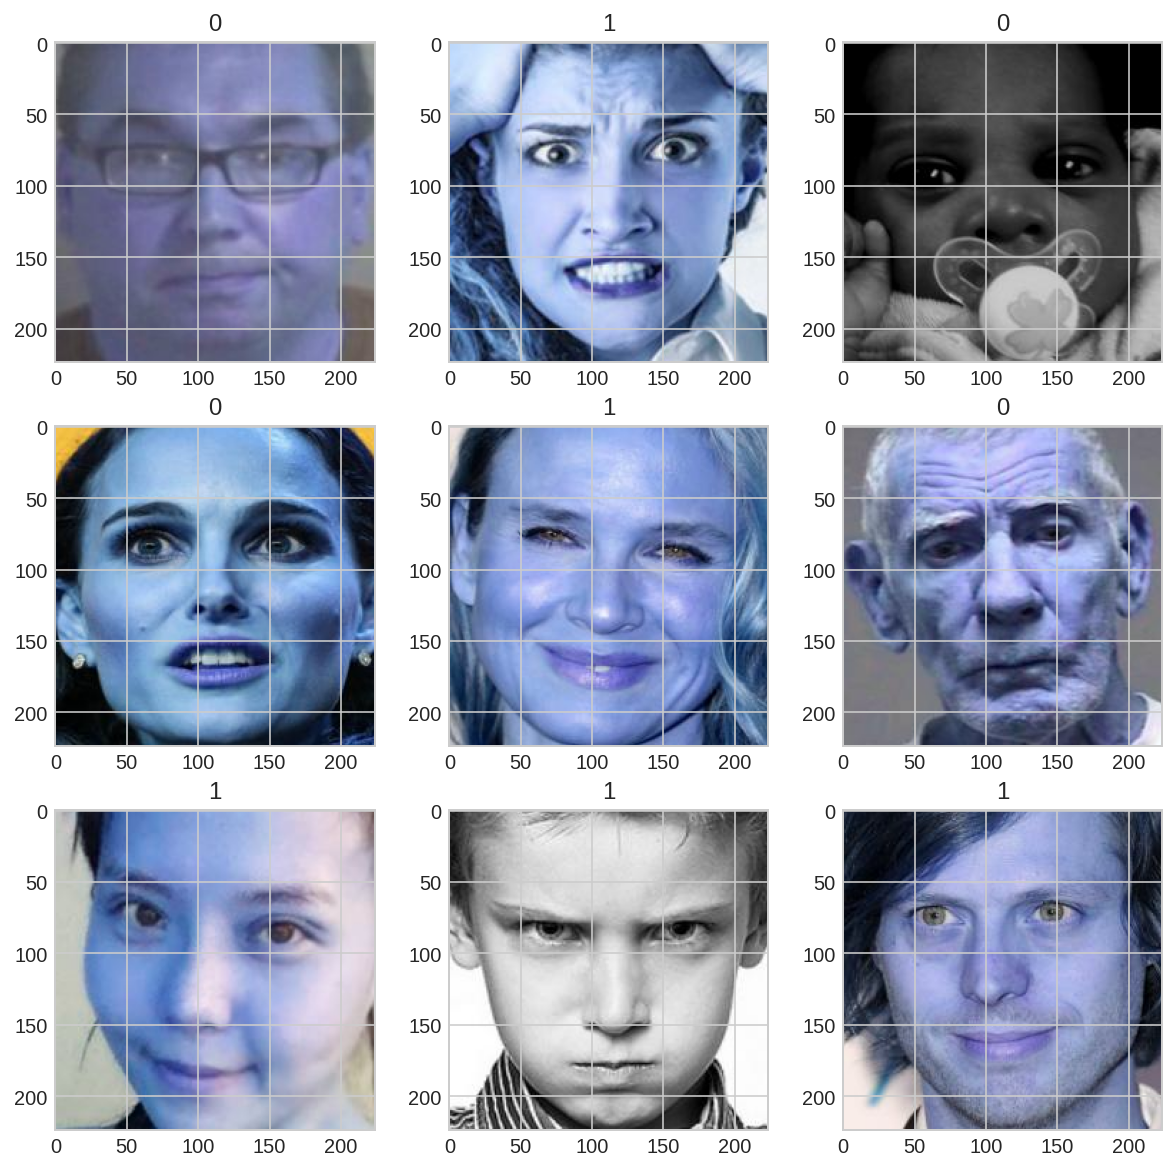

Showing wrong predictions
{326, 263, 8, 11, 140, 174, 210, 246, 125}


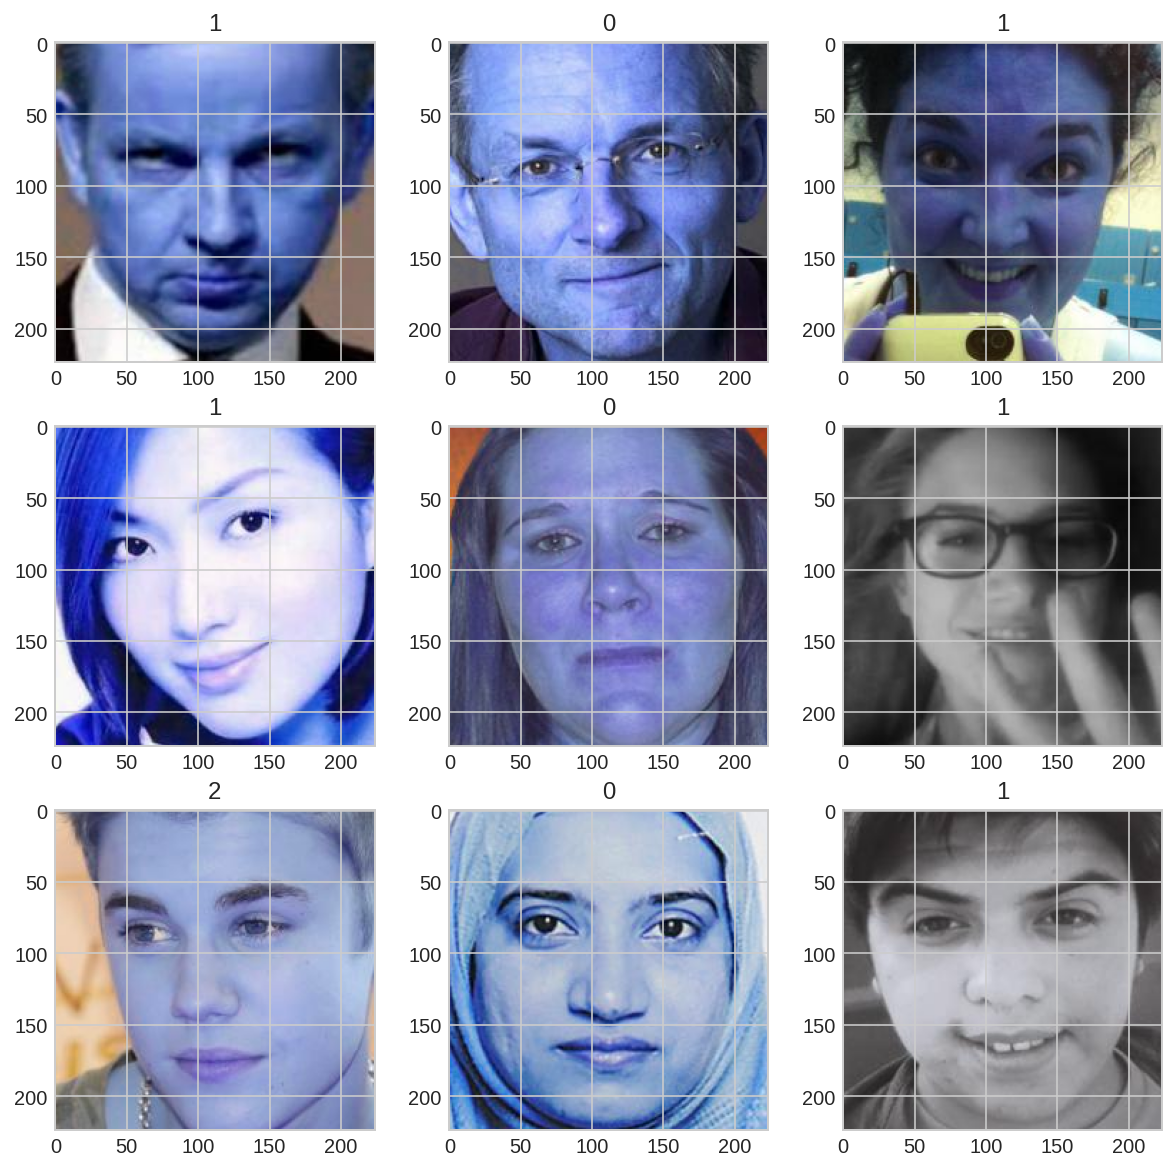

In [73]:
 #Seperating indices for correctly and incorrectly predicted samples
correct_preds = np.array(true_class) == np.array(predictions)
correct_inds, incorrect_inds = [],[]

for i,x in enumerate(correct_preds):
  if x:
    correct_inds.append(i)
  else:
    incorrect_inds.append(i)

#choose random correct and incorrect samples
correct_inds = set(np.random.choice(correct_inds, size=9))
incorrect_inds = set(np.random.choice(incorrect_inds, size=9))


print("Showing correct predictions")
print(correct_inds)
imgs, labels = [], []
for i,x in enumerate(correct_inds):
  imgs.append(cv2.imread(image_paths[x]))
  labels.append(predictions[x])
_, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    ax.imshow(img)
    ax.set_title(l)
plt.show()


print("Showing wrong predictions")
print(incorrect_inds)
imgs, labels = [], []
for i,x in enumerate(incorrect_inds):
  imgs.append(cv2.imread(image_paths[x]))
  labels.append(predictions[x])
_, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
   ax.imshow(img)
   ax.set_title(l)
plt.show()